In [1]:
import numpy as np
from kdg import kdn
from kdg.utils import generate_ellipse, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle, get_ece
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
import timeit

### Visualize the data

<AxesSubplot: >

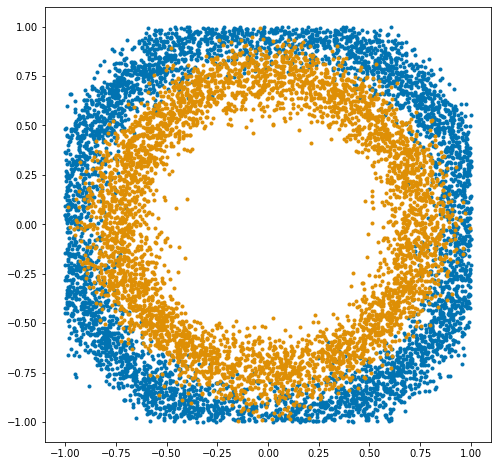

In [2]:
X, y = generate_ellipse(10000)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [4]:
# network architecture [1000, 1000, 1000, 1000, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

2023-09-01 14:34:14.611237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-01 14:34:14.611482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-01 14:34:14.787363: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Max


2023-09-01 14:34:14.994294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping


### Calculate posteriors and likelihoods using KDN

In [6]:
df = {}

t_0 = timeit.default_timer()
model_kdn = kdn(network=nn)
model_kdn.fit(X, y, k=2e8)
t_1 = timeit.default_timer()

print(f"Elapsed time: {t_1-t_0} s")
#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod = likelihoods_kdn_geod[:,1].reshape(400,400)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod'] = class1_likelihoods_geod
df['likelihood_class2_geod'] = class2_likelihoods_geod

Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.71s/it]


Elapsed time: 70.66899433300023 s
  84/5000 [..............................] - ETA: 9s

2023-09-01 14:36:13.836386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 9s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:24<00:00, 88.85s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:34<00:00, 90.91s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:28<00:00, 89.68s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:28<00:00, 89.74s/it]


In [7]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/ellipse_pdf.csv")
proba_true = 0.5*np.ones((500, 500))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = tmp.reshape(200, 200)
proba_true[150:350, 150:350] = 1 - tmp

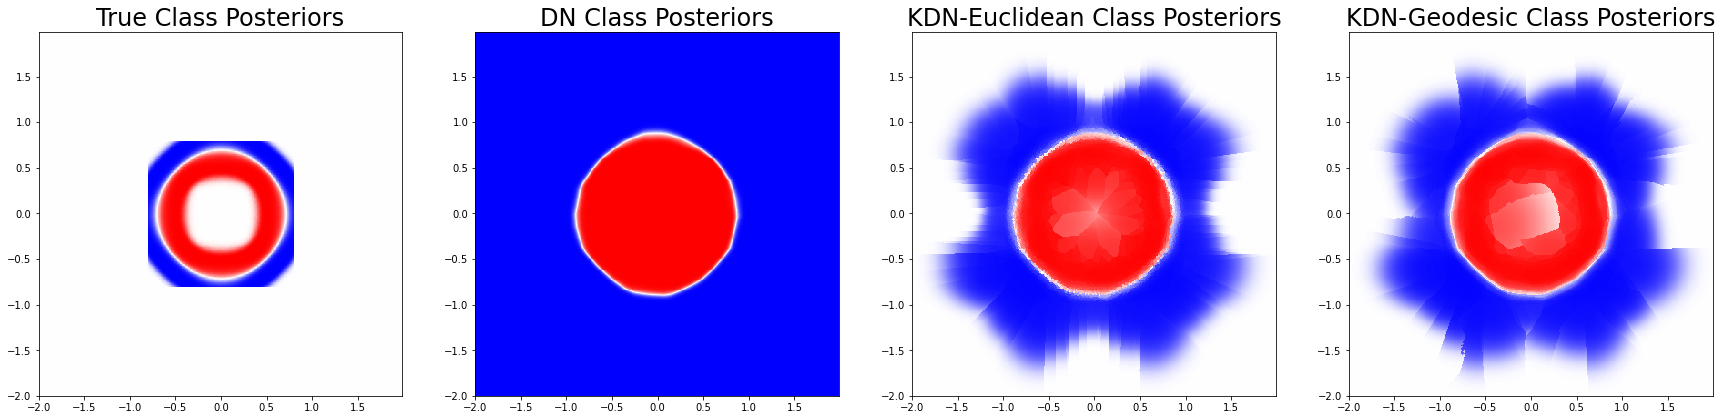

In [8]:
fig1, ax = plt.subplots(1, 4, figsize=(30, 150))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    1-posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    1-posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN-Euclidean Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    1-posterior_kdn_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDN-Geodesic Class Posteriors", fontsize=24)
ax[3].set_aspect("equal")
plt.show()

### Visualize class likelihoods

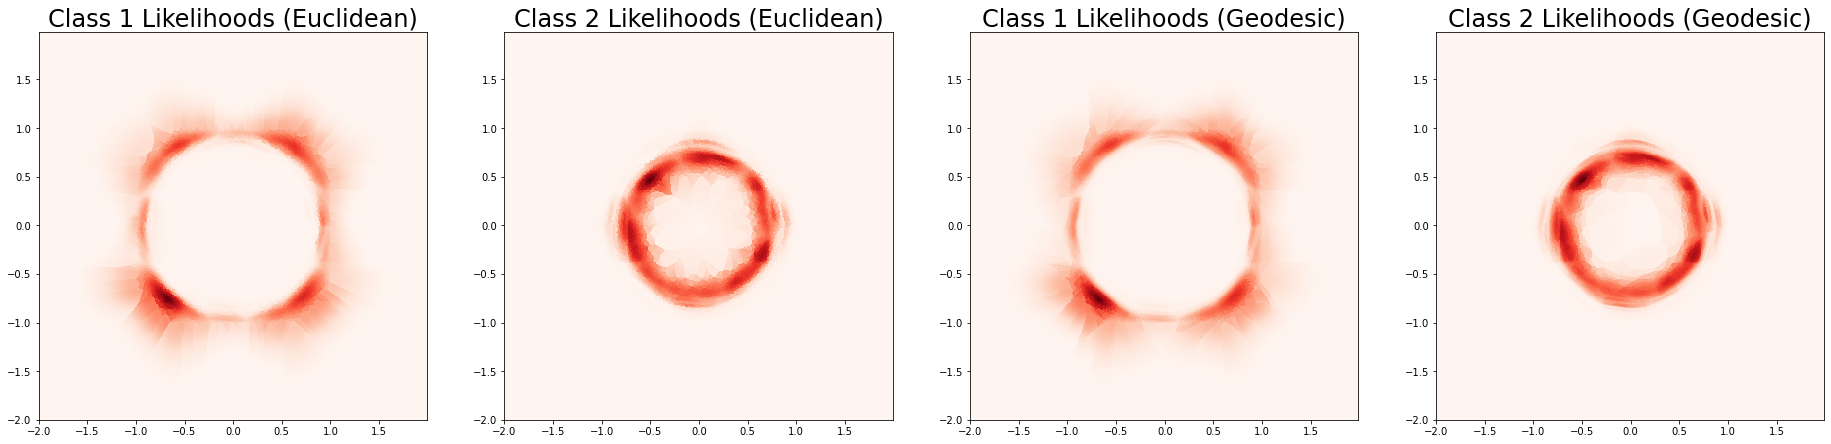

In [9]:
fig1, ax = plt.subplots(1, 4, figsize=(32, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods (Euclidean)", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods (Euclidean)", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    class1_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("Class 1 Likelihoods (Geodesic)", fontsize=24)
ax[2].set_aspect("equal")

ax3 = ax[3].imshow(
    class2_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("Class 2 Likelihoods (Geodesic)", fontsize=24)
ax[3].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [10]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/ellipse_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((true_posterior.ravel(), 1-true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_ellipse(sample)
    X_test, y_test = generate_ellipse(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e9)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)
    error_kdn_geod = 1 - np.mean(model_kdn.predict(X_test, distance='Geodesic')==y_test)
    error_dn = 1 - np.mean(np.argmax(model_kdn.network.predict(X_test),axis=1)==y_test)
    
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic')
    proba_dn = model_kdn.network.predict(grid_samples)
    
    hellinger_dis_kdn = hellinger(true_posterior, proba_kdn)
    hellinger_dis_kdn_geod = hellinger(true_posterior, proba_kdn_geod)
    hellinger_dis_dn = hellinger(true_posterior, proba_dn)
    
    
    return error_kdn, error_kdn_geod, error_dn, hellinger_dis_kdn, hellinger_dis_kdn_geod, hellinger_dis_dn

def experiment_out(in_sample, r, n_test):
    mmcOut_dn = np.zeros(len(r),dtype=float)
    mmcOut_kdn = np.zeros(len(r),dtype=float)
    mmcOut_kdn_geod = np.zeros(len(r),dtype=float)
    
    X, y = generate_ellipse(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e3)
    
    for ii, r_ in enumerate(r):
        X_ood = sample_unifrom_circle(n=n_test, r=r_)
        mmcOut_dn[ii] = np.mean(np.max(
            model_kdn.network.predict(X_ood), axis=1
            )
        )
        mmcOut_kdn[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
        mmcOut_kdn_geod[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood, distance='Geodesic'), axis=1))
    
    return mmcOut_kdn, mmcOut_kdn_geod, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_kdn_geod_med = []
error_kdn_geod_25 = []
error_kdn_geod_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_kdn_geod_med = []
hellinger_kdn_geod_25 = []
hellinger_kdn_geod_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []


mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_kdn_geod_med = []
mmcOut_kdn_geod_25 = []
mmcOut_kdn_geod_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []


#### do out-of-distribution results ####
r = np.arange(0,10.5,.5)
mmcOut_kdn = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_kdn_geod = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_dn = np.zeros((len(r),mc_reps), dtype=float)

for rep in range(mc_reps):
    mmcOut_kdn[:,rep], mmcOut_kdn_geod[:,rep], mmcOut_dn[:,rep] = experiment_out(1000, r, n_test)
    
    
mmcOut_kdn_med = np.median(mmcOut_kdn, axis=1)
mmcOut_kdn_25 = np.quantile(mmcOut_kdn, [0.25], axis=1)
mmcOut_kdn_75 = np.quantile(mmcOut_kdn, [0.75], axis=1)

mmcOut_kdn_geod_med = np.median(mmcOut_kdn_geod, axis=1)
mmcOut_kdn_geod_25 = np.quantile(mmcOut_kdn_geod, [0.25], axis=1)
mmcOut_kdn_geod_75 = np.quantile(mmcOut_kdn_geod, [0.75], axis=1)

mmcOut_dn_med = np.median(mmcOut_dn, axis=1)
mmcOut_dn_25 = np.quantile(mmcOut_dn, [0.25], axis=1)
mmcOut_dn_75 = np.quantile(mmcOut_dn, [0.75], axis=1)
    
        
#### do in-distribution results ####
for sample in sample_size:
    err_kdn = []
    err_kdn_geod = []
    err_dn = []
    hellinger_kdn = []
    hellinger_kdn_geod = []
    hellinger_dn = []
    
    for ii in range(mc_reps):
        a,b,c,d,e,f = experiment_in(sample, n_test, true_posterior) 
        
        err_kdn.append(a)
        err_kdn_geod.append(b)
        err_dn.append(c)
        hellinger_kdn.append(d)
        hellinger_kdn_geod.append(e)
        hellinger_dn.append(f)
        

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )
    
    error_kdn_geod_med.append(
        np.median(err_kdn_geod)
    )
    error_kdn_geod_25.append(
        np.quantile(err_kdn_geod, [0.25])[0]
    )
    error_kdn_geod_75.append(
        np.quantile(err_kdn_geod, [0.75])[0]
    )
    
    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )
    
    hellinger_kdn_geod_med.append(
        np.median(hellinger_kdn_geod)
    )
    hellinger_kdn_geod_25.append(
        np.quantile(hellinger_kdn_geod, [0.25])[0]
    )
    hellinger_kdn_geod_75.append(
        np.quantile(hellinger_kdn_geod, [0.75])[0]
    )
    
    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )
    
    

df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_kdn_geod_med'] = error_kdn_geod_med
df['error_kdn_geod_25'] = error_kdn_geod_25
df['error_kdn_geod_75'] = error_kdn_geod_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_kdn_geod_med'] = hellinger_kdn_geod_med
df['hellinger_kdn_geod_25'] = hellinger_kdn_geod_25
df['hellinger_kdn_geod_75'] = hellinger_kdn_geod_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25
df['mmcOut_kdn_75'] = mmcOut_kdn_75

df['mmcOut_kdn_geod_med'] = mmcOut_kdn_geod_med
df['mmcOut_kdn_geod_25'] = mmcOut_kdn_geod_25
df['mmcOut_kdn_geod_75'] = mmcOut_kdn_geod_75

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25
df['mmcOut_dn_75'] = mmcOut_dn_75

2023-09-01 15:06:45.058559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:06:49.625217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]
2023-09-01 15:07:08.809741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 71: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:07:17.726461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]
2023-09-01 15:07:36.799259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:07:43.858343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.16it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]
2023-09-01 15:08:03.212060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:08:08.648173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]
2023-09-01 15:08:28.154980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:08:34.042150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]
2023-09-01 15:08:53.171189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:08:58.385955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]
2023-09-01 15:09:17.514869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:09:23.955127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]
2023-09-01 15:09:43.091315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:09:49.876278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]
2023-09-01 15:10:09.141609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:10:15.018830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]
2023-09-01 15:10:33.827017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:10:41.467599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]
2023-09-01 15:11:00.242972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 271.84it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.50it/s]
2023-09-01 15:11:02.403054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:11:09.696417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.43it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.41it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 15:11:12.152855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:11:18.877088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.68it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 68.10it/s]
2023-09-01 15:11:20.909598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:11:27.573578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 286.04it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.91it/s]
2023-09-01 15:11:29.601226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:11:36.254619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 281.61it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.01it/s]
2023-09-01 15:11:38.322657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.86it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:11:45.074927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 252.05it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.29it/s]
2023-09-01 15:11:47.193094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:11:54.075026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.83it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.35it/s]
2023-09-01 15:11:56.137201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.86it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:12:02.916800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 292.73it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 77.44it/s]
2023-09-01 15:12:04.994499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:12:11.685508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 283.82it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.20it/s]
2023-09-01 15:12:13.724885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:12:20.470998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.35it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.27it/s]
2023-09-01 15:12:22.503945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:12:29.180051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 146.33it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.69it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:12:30.847124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:12:38.646646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 144.66it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.31it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:12:42.217217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:12:50.018818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 103: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 158.01it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.04it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:12:52.200704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:13:00.166366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 132: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.37it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:13:03.240711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.60it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:13:11.553739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 62: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 165.65it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.02it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:13:13.201830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:13:21.087159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 159.78it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.73it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:13:22.614092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:13:30.616410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 82: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 143.79it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.52it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:13:32.555696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:13:40.511700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 97: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 155.13it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.54it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:13:42.657095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:13:50.494271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 196: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 141.32it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.63it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:13:54.198187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:14:02.311494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 123: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 129.69it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.04it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 15:14:04.991164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:14:12.857503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 57: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.10it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.19it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:14:17.509617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:14:34.228823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 103: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.84it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.93it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:14:41.500431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:14:58.109890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.64it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.42it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:15:01.433215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:15:18.204541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.22it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.23it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:15:20.918659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:15:37.755717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 68: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.44it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.40it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:15:43.080501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


1250/1250 [==============================] - 3s 2ms/step


2023-09-01 15:16:00.321535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.22it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.56it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:16:04.144604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:16:21.220108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.21it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.62it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 15:16:26.221264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:16:43.341721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.69it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]
2023-09-01 15:16:46.927392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:17:03.771813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.23it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.56it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:17:09.547886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:17:26.736083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.80it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.43it/s]


32/32 [==============================] - 0s 2ms/step


2023-09-01 15:17:31.767217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:17:48.483273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:17:53.220457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.60s/it]


1250/1250 [==============================] - 3s 2ms/step


2023-09-01 15:18:21.595926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:18:31.577897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.62s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:18:59.904273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:19:09.782902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.58s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:19:37.881663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:19:47.743531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.55s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:20:15.715875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 62: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:20:24.720226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.58s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:20:52.832895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 15:21:00.747834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.66s/it]


1250/1250 [==============================] - 3s 2ms/step


2023-09-01 15:21:29.850199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


22/32 [===================>..........] - ETA: 0s

2023-09-01 15:21:35.897454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.58s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:22:04.237503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 15:22:11.865280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.61s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:22:40.131831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 15:22:47.369761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.75s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:23:16.359878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 88: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


24/32 [=====================>........] - ETA: 0s

2023-09-01 15:23:28.534428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.66s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:23:57.213176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.97s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]

 1/32 [..............................] - ETA: 2s


2023-09-01 15:24:35.767230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.70s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:27:10.572116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.96s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

 1/32 [..............................] - ETA: 2s


2023-09-01 15:27:59.451680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.91s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:30:30.252459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.97s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:31:20.126831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.33s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:33:53.098583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.03s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:34:53.695051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.83s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:37:29.166653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.00s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:38:15.371578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.57s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:40:49.475754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.96s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:41:28.542696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.70s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:44:03.312688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.01s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:44:43.686990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.20s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:47:16.416169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.90s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]

 1/32 [..............................] - ETA: 2s


2023-09-01 15:47:55.318477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.07s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:50:27.001339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 70: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.96s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:51:26.036465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.59s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:53:55.124326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.86s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 15:54:38.627037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.27s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 15:57:00.993773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.54s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]

24/32 [=====================>........] - ETA: 0s


2023-09-01 15:58:52.163851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:37<00:00, 79.59s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 16:05:37.271431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.94s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]


32/32 [==============================] - 0s 3ms/step


2023-09-01 16:07:37.065704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:01<00:00, 84.34s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 16:14:46.350315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.32s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


25/32 [======================>.......] - ETA: 0s

2023-09-01 16:16:42.705444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:13<00:00, 86.69s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 16:24:03.895934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.40s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]

21/32 [==================>...........] - ETA: 0s


2023-09-01 16:26:06.606864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:10<00:00, 86.18s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 16:33:25.264807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.37s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


23/32 [====================>.........] - ETA: 0s

2023-09-01 16:35:26.362628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:18<00:00, 87.78s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 16:42:52.933877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.52s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


24/32 [=====================>........] - ETA: 0s

2023-09-01 16:44:51.334176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:10<00:00, 86.09s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 16:52:09.547198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.66s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


32/32 [==============================] - 0s 3ms/step


2023-09-01 16:54:01.562617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:01<00:00, 84.34s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 17:01:10.846092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.68s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]
2023-09-01 17:03:10.252292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:04<00:00, 84.90s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 17:10:22.295800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.30s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]
2023-09-01 17:12:33.869470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:54<00:00, 82.81s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 17:19:36.242532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.19s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


23/32 [====================>.........] - ETA: 0s

2023-09-01 17:21:17.547285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:29<00:00, 89.90s/it]


1250/1250 [==============================] - 2s 2ms/step


### Save the result

In [11]:
import pickle
filename = 'results/circle.pickle'

with open(filename, 'wb') as f:
    pickle.dump(df,f)

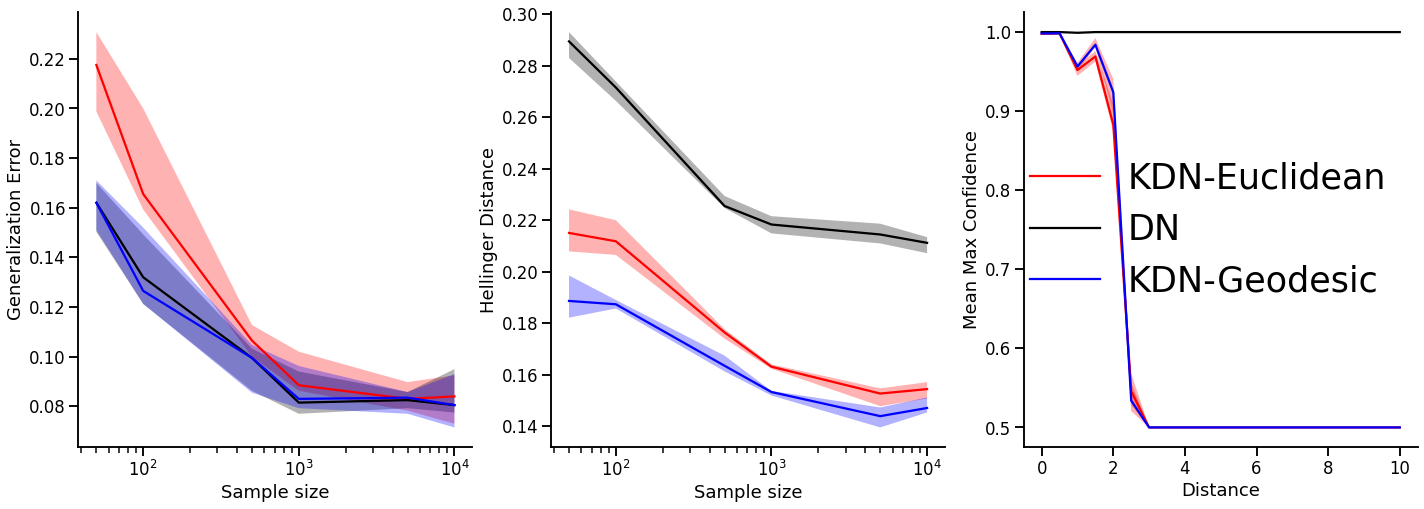

In [12]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,3, figsize=(24,8))


ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN-Euclidean')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')
ax[0].plot(sample_size, df['error_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)
ax[0].fill_between(sample_size, df['error_kdn_geod_25'], df['error_kdn_geod_75'], facecolor='b', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN-Euclidean')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')
ax[1].plot(sample_size, df['hellinger_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_kdn_geod_25'], df['hellinger_kdn_geod_75'], facecolor='b', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[2].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN-Euclidean')
ax[2].plot(r, df['mmcOut_dn_med'], c="k", label='DN')
ax[2].plot(r, df['mmcOut_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[2].fill_between(r, df['mmcOut_kdn_25'].ravel(), df['mmcOut_kdn_75'].ravel(), facecolor='r', alpha=.3)
ax[2].fill_between(r, df['mmcOut_dn_25'].ravel(), df['mmcOut_dn_75'].ravel(), facecolor='k', alpha=.3)
ax[2].fill_between(r, df['mmcOut_kdn_geod_25'].ravel(), df['mmcOut_kdn_geod_75'].ravel(), facecolor='r', alpha=.3)

#ax[3].set_xscale('log')
ax[2].set_xlabel('Distance')
ax[2].set_ylabel('Mean Max Confidence')

ax[2].legend(fontsize=35, frameon=False)

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)